In [41]:
import base64
import io
import pickle
import numpy as np
import math
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm


TORCH VERSION: 2.0.1+cu117


Code is an amalgamation of https://arxiv.org/pdf/2101.08176 and https://github.com/TinyVolt/normalizing-flows/blob/main/1d_composing_flows/ComposableFlows1d.ipynb

# Parameter Setting

In [42]:
# Physics Params
E0 = 500            # Energy of Hard Process
Lambda_QCD = 0.2    # Lambda QCD
cutoff = 0.01      # Cutoff for minimum lambda, ~ LambdaQCD / E0


# Training Params
num_epochs = 2500
lr = .01
batch_size = 512
num_points = 50 # we define a prior on each point along the horizontal axis
                # eventually this should be made large

In [43]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
    print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


In [44]:
def grab(var):
    return var.detach().cpu().numpy()

## Define a prior distribution


Standard normal

In [45]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
        torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return logp
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

# Define the flow

Very simple 1-dimensional layers


In [46]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal 

class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1)
        log_dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1).log()
        return z, log_dz_by_dx

class LogitTransform(nn.Module):
    def __init__(self, alpha):
        super(LogitTransform, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        x_new = (self.alpha/2 + (1-self.alpha)*x).to(torch_device)
        z = torch.log(x_new) - torch.log(1-x_new)
        log_dz_by_dx = torch.log(torch.FloatTensor([1-self.alpha]).to(torch_device)) - torch.log(x_new) - torch.log(1-x_new)
        return z, log_dz_by_dx
        

class FlowComposable1d(nn.Module):
    def __init__(self, flow_models_list):
        super(FlowComposable1d, self).__init__()
        self.flow_models_list = nn.ModuleList(flow_models_list).to(torch_device)

    def forward(self, x):
        z, sum_log_dz_by_dx = x, 0
        for flow in self.flow_models_list:
            z, log_dz_by_dx = flow(z)
            sum_log_dz_by_dx += log_dz_by_dx
        return z, sum_log_dz_by_dx

In [47]:
# Loss function

# # toy model
# def target_logp_order1(x): # 1st order approximation to the function

#     target_p = 1.5*(-x**2 + 1)

#     return torch.log(target_p)
# # """
def calc_dkl(logp, logq):
    return (logq - logp).sum() # reverse KL, assuming samples from q

# Define the probability density 

In [48]:
def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def target_logp_order1(x): # 1st order approximation to the function

    alpha_s_scale = alpha_s(x * E0) # GeV
    C_F = 4/3
    C_A = 3
    
    p_order1 = -(alpha_s_scale * C_F / (1 * np.pi)) * torch.log(x ) / x
        
    p_order1[x < cutoff] = 0

    # # normalize so the integral is 1
    # dx = x[1] - x[0]
    # p_order1 = p_order1 / p_order1.sum()  / dx
        
    log_p_order1 = torch.log(p_order1)
        
    

    return torch.nan_to_num(log_p_order1, nan = 0.0)


# # toy model
# def target_logp_order1(x): # 1st order approximation to the function
    
#     sigmasq = 1
#     mean = 3
        
#     ll = (1.0/(np.sqrt(2*np.pi*sigmasq)))*torch.exp(-0.5*(x+mean)**2/sigmasq)
     
#     return torch.nan_to_num(torch.log(ll))

# # """
# # toy model
# def target_logp_order1(x): # 1st order approximation to the function

#     target_p = 1.5*(-x**2 + 1)

#     return torch.log(target_p)
# # """

# Model Initialization and Training

In [49]:
def initialize_model():

    # Initialize the prior
    prior = SimpleNormal(torch.zeros(num_points), torch.ones(num_points))

    # Initialize the model
    # Model archutecture not optimized at all
    flow_models_list = [Flow1d(2), LogitTransform(0.1), Flow1d(2), LogitTransform(0.1), Flow1d(2)]
    flow = FlowComposable1d(flow_models_list)
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

    return flow, optimizer, prior


def train_model(lambda_star):

    train_losses = []
    flow, optimizer, prior = initialize_model()


    for epoch in tqdm(range(num_epochs)):
    
    
        optimizer.zero_grad()
        
        # APPLY FLOW TO PRIOR
        # draw samples from prior
        z = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)
        logq = prior.log_prob(z) # shape logq: (batch_size, num_points)
        x, logJ = flow(z)
        logJ = logJ.reshape(batch_size, num_points)

        x = x.reshape(batch_size, num_points) 
        mask = 1
        
        # need to reshape the outputs match those from the previous step
        logq = logq - logJ 

        # CALCULATE THE TARGET
        logp = target_logp_order1(x)

        # Mean over the points to get the total logp and logq
        regulator = 1
        total_logq = torch.nanmean(mask * logq, dim=1) #/ (mask.sum() + regulator)
        total_logJ = torch.nanmean(mask * logJ, dim=1) #/ (mask.sum() + regulator)
        total_logp = torch.nanmean(mask * logp, dim=1) #/ (mask.sum() + regulator)

        # We DON'T want to sum, we want to mean in the loss, since the effective batch size can change

            
        # CALCULATE THE LOSS
        loss = calc_dkl(total_logp, total_logq)
        
        loss.backward()
        optimizer.step()
            
        train_losses.append(grab(loss))


    return flow, train_losses



In [50]:
lambda_stars = [0.0,]
flows = []
train_losses = []

for lambda_star in lambda_stars:
    flow, train_loss = train_model(lambda_star)
    flows.append(flow)
    train_losses.append(train_loss)



100%|██████████| 2500/2500 [00:49<00:00, 50.84it/s]


lambda_star = 0.0, losses = [array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf), array(inf),

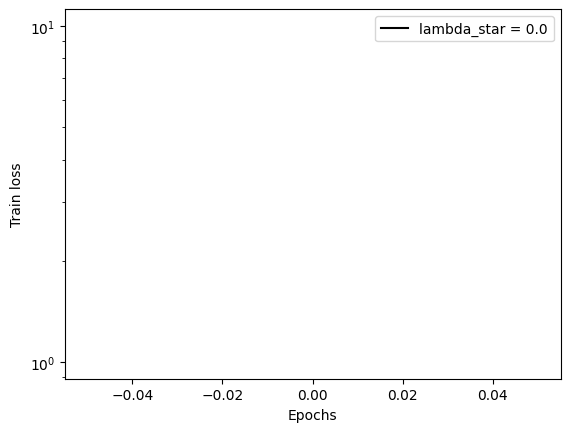

In [51]:
plt.figure()

for i, lambda_star in enumerate(lambda_stars[::-1]):
    plt.plot(train_losses[i], label = f"lambda_star = {lambda_star}", color = (i/len(lambda_stars), 0, 0))
    print(f"lambda_star = {lambda_star}, losses = {train_losses[i]}")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.yscale('log')
plt.show()

[[0.255067  ]
 [0.0054359 ]
 [0.00379506]
 ...
 [0.14005454]
 [0.09518582]
 [0.09854729]]


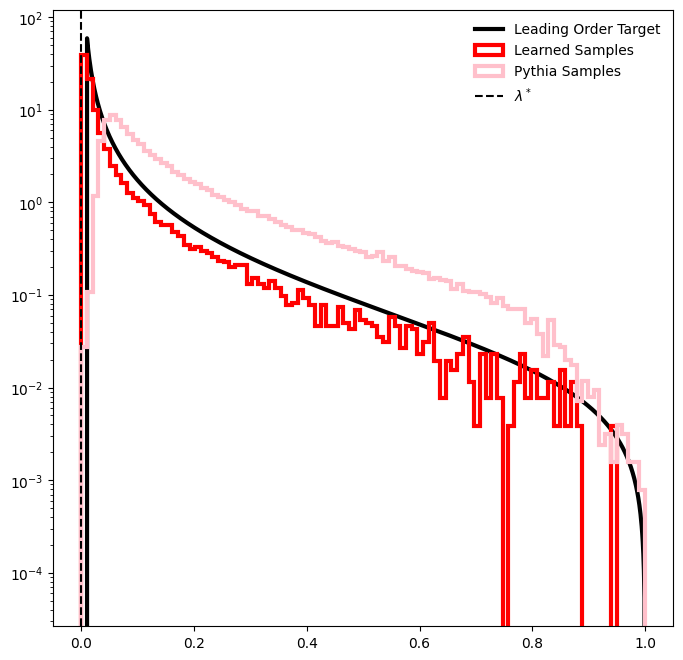

In [52]:
# plot output

for (i, lambda_star) in enumerate(lambda_stars):

    x_test = torch.linspace(0, 1, 1000)


    plt.figure(figsize = (8,8))

    # plot the target
    y_test = np.exp(grab(target_logp_order1(x_test.to(torch_device)))) 
    y_test = y_test / np.sum(y_test) / (x_test[1] - x_test[0]) 
    plt.plot(grab(x_test), y_test , label = "Leading Order Target", color = "black", lw = 3)

    # plot transformed prior
    prior = SimpleNormal(torch.zeros(num_points), torch.ones(num_points))
    x = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)    
    x, logJ = flow(x)
    # need to reshape the outputs match those from the previous step
    x = grab(x.reshape(-1,1) )
    print(x)


    plt.hist(x, bins = np.linspace(0, 1, 100), density = True, label = "Learned Samples", histtype='step', color = "red", lw = 3)


    # Plot the samples as a baseline
    np_angularities = np.load("normalized_angularity.npy")
    plt.hist(np_angularities, bins = np.linspace(-0, 1, 100), density = True, label = "Pythia Samples", histtype='step', color = "pink", lw = 3)

    # Vertical line at lambda_star
    plt.axvline(lambda_star, color = "black", linestyle = "--", label = r"$\lambda^*$")

    plt.yscale("log")
    plt.legend(frameon = False)
    plt.show()



